In [175]:
# importing the library 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libs
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score


In [2]:
dataframe = pd.read_csv("Fraud.csv")
    

In [158]:
df =dataframe.copy()
df = df[:10000]

# To begin with, we have step col in dataset, which elicits the time at which transaction is done. 
# Therefore, it is curtial to convert it into convinient format.
# here, i am going to convert each steps into timeDelta format, and soon i will transform it into other format.

df["step"] = pd.to_timedelta(df["step"], unit='h')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,0 days 01:00:00,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,0 days 01:00:00,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,0 days 01:00:00,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,0 days 01:00:00,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,0 days 01:00:00,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [159]:


# if there exists any null values, i am imputnig it will mean value(column wise)
df.fillna(df.mean(axis=1))

# converting categorical variable into numertical with the help of one hot encoding. 
ct = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(), [1])
    ],
    remainder='passthrough'
)

# Fit and transform the data
df_encoded = ct.fit_transform(df)

# Convert the result to a DataFramevs
df_encoded = pd.DataFrame(df_encoded, columns=ct.get_feature_names_out())

C:\Users\ankit\AppData\Local\Temp\ipykernel_4688\393170218.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.fillna(df.mean(axis=1))


In [160]:
df_encoded.head()

,encoder__type_CASH_IN,encoder__type_CASH_OUT,encoder__type_DEBIT,encoder__type_PAYMENT,encoder__type_TRANSFER,remainder__step,remainder__amount,remainder__nameOrig,remainder__oldbalanceOrg,remainder__newbalanceOrig,remainder__nameDest,remainder__oldbalanceDest,remainder__newbalanceDest,remainder__isFraud,remainder__isFlaggedFraud
0,0.0,0.0,0.0,1.0,0.0,0 days 01:00:00,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,0.0,0.0,0.0,1.0,0.0,0 days 01:00:00,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,0.0,0.0,0.0,0.0,1.0,0 days 01:00:00,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0
3,0.0,1.0,0.0,0.0,0.0,0 days 01:00:00,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0
4,0.0,0.0,0.0,1.0,0.0,0 days 01:00:00,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Here, we have two categorical variable and those are ID/NAME of sender and recipient, and these two feature are very useful. We can identify the suspicious trasaction by looking at the frequency of homy transcation is commited by send and hwo many time reciever had recieved a money. For instance, if one sender send money to same reciver very frequent, thet means there must be somethig that is fishy between these two individuals. Hence, it is necessary to keep information of both columns for better understanding of behaviour. 

In [161]:

df_encoded['customer_start_freq'] = df_encoded.groupby('remainder__nameOrig')['remainder__nameOrig'].transform('count')
df_encoded['customer_recipient_freq'] = df_encoded.groupby('remainder__nameDest')['remainder__nameDest'].transform('count')
df_encoded = df_encoded.drop('remainder__nameDest', axis=1)
df_encoded = df_encoded.drop('remainder__nameOrig', axis=1)

#### In the following code shell, we had a step column in formant of time delta, but hear i have converted it into the three different columns since these coulumn helps the machine learnig model to get better idea of fraudant transcation. 

In [162]:
df_encoded['days'] = df_encoded['remainder__step'].dt.days
df_encoded['hours'] = df_encoded['remainder__step'].dt.components.hours
df_encoded['minutes'] = df_encoded['remainder__step'].dt.components.minutes
df_encoded  = df_encoded.drop("remainder__step", axis=1)
col_to_move = df_encoded.pop('remainder__isFraud')
df_encoded.insert(len(df_encoded.columns), 'remainder__isFraud', col_to_move)


In [163]:
#separating labels and non labled data
X = df_encoded.iloc[:, :-1].values
Y= df_encoded.iloc[:, -1].values

# spliting data set into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [150]:
# y_train =  y_train.reshape(len(y_train), 1)
# y_test =  y_test.reshape(len(y_test), 1)
# y_train = np.array(y_train)
# y_test = np.array(y_test)

## Scaling the data

In [166]:
scaler = StandardScaler()
X_train[:, 5:10] = scaler.fit_transform(X_train[:, 5:10])
X_test[:, 5:10] = scaler.transform(X_test[:, 5:10])


In [168]:
# Furthermore, ANN and other machine learning model accepts the either float32 ot float64 datatype
# and data type of our data is "float"
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_train = y_train.astype(np.float64)
y_test = y_test.astype(np.float64)

<class 'numpy.ndarray'>


## Despite all these, our data set imbalanced. You might be wondering why. Let me show you in upcoming shell.

In [180]:
# Number of negative examples
print(np.count_nonzero(y_train))
print(np.count_nonzero(y_test))

# number of positive examples
print(y_train.size  - np.count_nonzero(y_train))
print(y_test.size  - np.count_nonzero(y_test))


54
14
7946
1986


### it is evident from the above result that, we have a dataset that is imbalanced. Therefore, we can not just apply the machine learing model on this, and if we ended up trying out this, result are likely to be missleading. 

### ANN on imbalanced dataset

In [173]:

model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=32, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# train model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.2f}')
print(f'Test Accuracy: {accuracy:.2f}')

Epoch 1/10
250/250 [==============================] - 1s 3ms/step - loss: 0.0847 - accuracy: 0.9895 - val_loss: 0.0413 - val_accuracy: 0.9930
Epoch 2/10
250/250 [==============================] - 1s 2ms/step - loss: 0.0370 - accuracy: 0.9933 - val_loss: 0.0309 - val_accuracy: 0.9935
Epoch 3/10
250/250 [==============================] - 1s 3ms/step - loss: 0.0310 - accuracy: 0.9936 - val_loss: 0.0282 - val_accuracy: 0.9935
Epoch 4/10
250/250 [==============================] - 1s 4ms/step - loss: 0.0278 - accuracy: 0.9936 - val_loss: 0.0257 - val_accuracy: 0.9935
Epoch 5/10
250/250 [==============================] - 1s 4ms/step - loss: 0.0269 - accuracy: 0.9935 - val_loss: 0.0235 - val_accuracy: 0.9935
Epoch 6/10
250/250 [==============================] - 1s 4ms/step - loss: 0.0254 - accuracy: 0.9936 - val_loss: 0.0249 - val_accuracy: 0.9935
Epoch 7/10
250/250 [==============================] - 1s 4ms/step - loss: 0.0263 - accuracy: 0.9935 - val_loss: 0.0232 - val_accuracy: 0.9935
Epoch 

### 99% precent accuracy - somethings seems fishy right !!


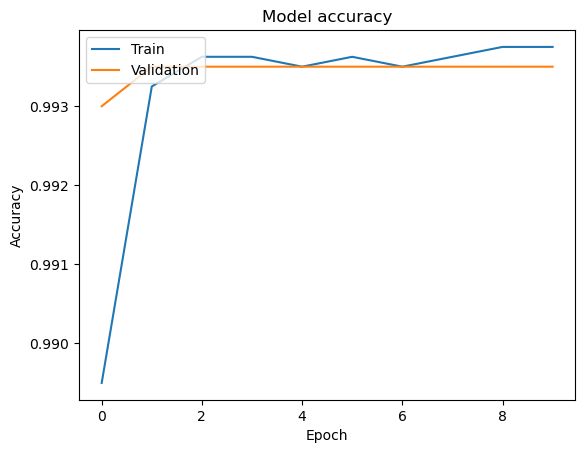

In [174]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

63/63 [==============================] - 0s 2ms/step


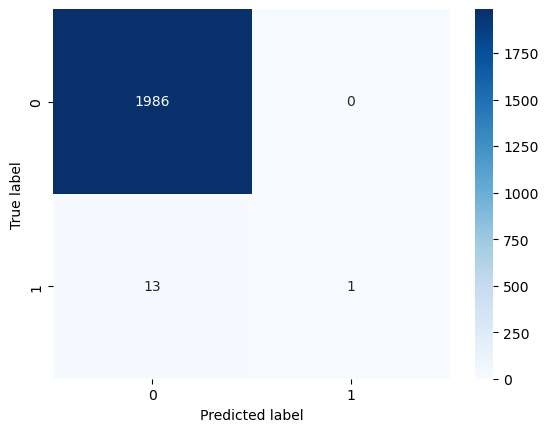

In [176]:
y_pred_ann = model.predict(X_test)
y_pred_ann = (y_pred_ann> 0.5)
cm = confusion_matrix(y_test, y_pred_ann)

# Create a heatmap to visualize the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Random forest

In [213]:
# let 
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [214]:
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[177   0]
 [  2 181]]


0.9944444444444445

In [216]:
importances = classifier.feature_importances_

# Print the feature importances
for feature, importance in zip(pd.DataFrame(X).columns, importances):
    print(f'{feature}: {importance:.2f}')

0: 0.00
1: 0.00
2: 0.00
3: 0.01
4: 0.00
5: 0.03
6: 0.33
7: 0.02
8: 0.01
9: 0.00
10: 0.56
11: 0.01
12: 0.00
13: 0.00
14: 0.00
15: 0.01
16: 0.00
17: 0.00
18: 0.00
19: 0.01


### Solving the above problem
To address this issue, i am goint to try oversampling technique

In [181]:
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from collections import Counter

# Create an imbalanced dataset
X, y = make_classification(n_classes=2, class_sep=2,
                           weights=[0.1, 0.9], n_informative=3,
                           n_redundant=1, flip_y=0, n_features=20,
                           n_clusters_per_class=1, n_samples=1000,
                           random_state=10)

# Print the original class distribution
print(f'Original class distribution: {Counter(y)}')

# Perform oversampling using SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

# Print the resampled class distribution
print(f'Resampled class distribution: {Counter(y_resampled)}')

Original class distribution: Counter({1: 900, 0: 100})
Resampled class distribution: Counter({0: 900, 1: 900})


#### Now we have right distribution of data in order to apply machine learning model

In [197]:
# spliting newly genaretd X_resampled and Y_resampled

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 0)

### Now, let's apply ANN to new train and test set

In [194]:

model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=32, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# train model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
45/45 [==============================] - 1s 7ms/step - loss: 0.5860 - accuracy: 0.7132 - val_loss: 0.2959 - val_accuracy: 0.9694
Epoch 2/10
45/45 [==============================] - 0s 4ms/step - loss: 0.1981 - accuracy: 0.9653 - val_loss: 0.0923 - val_accuracy: 0.9833
Epoch 3/10
45/45 [==============================] - 0s 3ms/step - loss: 0.0739 - accuracy: 0.9868 - val_loss: 0.0461 - val_accuracy: 0.9972
Epoch 4/10
45/45 [==============================] - 0s 3ms/step - loss: 0.0476 - accuracy: 0.9917 - val_loss: 0.0313 - val_accuracy: 0.9972
Epoch 5/10
45/45 [==============================] - 0s 5ms/step - loss: 0.0311 - accuracy: 0.9944 - val_loss: 0.0246 - val_accuracy: 0.9972
Epoch 6/10
45/45 [==============================] - 0s 4ms/step - loss: 0.0218 - accuracy: 0.9951 - val_loss: 0.0205 - val_accuracy: 0.9972
Epoch 7/10
45/45 [==============================] - 0s 3ms/step - loss: 0.0181 - accuracy: 0.9965 - val_loss: 0.0180 - val_accuracy: 0.9972
Epoch 8/10
45/45 [==

In [208]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


y_pred = model.predict(X_test)
y_pred_ann = (y_pred > 0.5)

# AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred)
print(f'AUC-ROC: {auc_roc:.2f}')
print()

# accuracy
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.2f}')
print(f'Test Accuracy: {accuracy:.2f}')
print()

# f-1 score
f1 = f1_score(y_test, y_pred_ann)
print(f'F1 score: {f1:.2f}')
print()

# k fold cross validation
accuracies =  cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation {:.2f} %".format(accuracies.std()*100))
print()

cm = confusion_matrix(y_test,y_pred_ann)
print("confusion_matrix")
print(cm)

12/12 [==============================] - 0s 1ms/step
AUC-ROC: 1.00

12/12 [==============================] - 0s 1ms/step - loss: 0.0155 - accuracy: 0.9972
Test Loss: 0.02
Test Accuracy: 1.00

F1 score: 1.00

Accuracy 99.93 %
Standard Deviation 0.21 %

confusion_matrix
[[177   0]
 [  1 182]]


In [212]:
# Calculate feature importances
importances = classifier.feature_importances_

# Print the feature importances
for feature, importance in zip(df.feature_names, importances):
    print(f'{feature}: {importance:.2f}')

AttributeError: 'DataFrame' object has no attribute 'feature_names'

In [209]:
from matplotlib.colors import ListedColormap
X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Kernel SVM (Training set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

ValueError: X has 2 features, but RandomForestClassifier is expecting 16 features as input.

In [ ]:
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Kernel SVM (Test set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()